Colab Preperation for Run

In [1]:
!git clone  https://github.com/noabendavid/Deep_Learning_Final_Project.git
%cd Deep_Learning_Final_Project
!ls


Cloning into 'Deep_Learning_Final_Project'...
remote: Enumerating objects: 5857, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 5857 (delta 0), reused 5 (delta 0), pack-reused 5850 (from 1)
Receiving objects: 100% (5857/5857), 1.13 GiB | 19.97 MiB/s, done.
Resolving deltas: 100% (6/6), done.
Updating files: 100% (5869/5869), done.
/content/Deep_Learning_Final_Project
data  main_notebook.ipynb  requirements.txt  sam.py  vit.py


In [ ]:
!pip install -r requirements.txt

In [ ]:
# import os
# os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"
# os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"
# import tensorflow as tf
# gpus = tf.config.list_physical_devices('GPU')
# if gpus:
#     for g in gpus:
#         tf.config.experimental.set_memory_growth(g, True)
# print("GPUs:", gpus)



## 1) Setup and Imports


In [3]:

import os, copy, random, sys
import importlib.util
from dataclasses import dataclass, asdict
from pathlib import Path
from collections import Counter

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import datasets, transforms
from torchvision.transforms import RandAugment
from sklearn.metrics import (classification_report, confusion_matrix, roc_curve,auc, precision_recall_curve, average_precision_score, f1_score)
from sklearn.model_selection import StratifiedShuffleSplit
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tabulate

from PIL import Image, ImageOps
from sam import SAM

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.models import Model

SEED = 42
random.seed(SEED); np.random.seed(SEED)
torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True
torch.backends.cuda.enable_flash_sdp(True)
torch.backends.cuda.enable_mem_efficient_sdp(True)
torch.backends.cuda.enable_math_sdp(True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)


Device: cuda


## 2) Import VIT implementation `vit.py`


In [4]:

VIT_PY_PATH = 'vit.py'
assert os.path.exists(VIT_PY_PATH), f'Could not find {VIT_PY_PATH}'
spec = importlib.util.spec_from_file_location("my_vit", VIT_PY_PATH)
vit = importlib.util.module_from_spec(spec)
sys.modules["my_vit"] = vit
spec.loader.exec_module(vit)

print("Found in vit.py ->",
      "ViTClassifier:", hasattr(vit, 'ViTClassifier'),
      "| build_transformer:", hasattr(vit, 'build_transformer'))

Found in vit.py -> ViTClassifier: True | build_transformer: True


In [5]:
# Sanity check
B, C, H, W = 2, 1, 224, 224
x = torch.randn(B, C, H, W)

vit_build = vit.build_transformer(x, patch_size=16, d_model=384, Nx=8, h=6, d_ff=1536)
y = vit_build(x)
assert y.shape == (B, 1 + (H//16)*(W//16), 384)

head = vit.ViTClassifier(x, num_classes=2, d_model=384)

logits = head(x)
assert logits.shape == (B, 2)
print("OK!")
del vit_build, head, logits

OK!



## 3) Configuration


In [6]:
@dataclass
class Config:
    # paths
    data_dir = './data/chest_xray'
    output_dir = './outputs'

    # data / transforms
    img_size = 224

    # optimization
    epochs = 20
    lr = 1e-4
    weight_decay = 0.05

    # SAM
    use_sam = False
    sam_rho = 0.05
    sam_adaptive = True

    # model vit
    patch_size = 16
    d_model = 768
    num_classes = 2

    #cnn
    batch_size = 32

    # dataloader
    num_workers = 2
    pin_memory = False

cfg = Config()
print(cfg)


Config()



## 4) Utility functions

In [7]:
def display_df(df: pd.DataFrame, max_rows: int = 20, max_cols: int = 20):
    # Set Pandas display options (affects Jupyter and terminal)
    pd.set_option('display.max_rows', max_rows)
    pd.set_option('display.max_columns', max_cols)
    pd.set_option('display.max_colwidth', None)

    # Detect if we're in a Jupyter-like environment
    if 'ipykernel' in sys.modules:
        # Pretty HTML display for notebooks
        from IPython.display import display
        display(df)
    else:
        # Pretty table for terminal
        print(tabulate(df, headers='keys', tablefmt='psql', showindex=False))

def class_counts(path):
    data_splits = ['train', 'val', 'test']
    # --- Class counts per split
    counts = []
    for split in data_splits:
        split_path = data_root / split
        if not split_path.exists():
            raise FileNotFoundError(f"Missing split folder: {split_path}")
        ds = datasets.ImageFolder(split_path)
        class_names = ds.classes
        c = Counter([label for _, label in ds.samples])
        for cls_idx, cls_name in enumerate(class_names):
            counts.append({'split': split, 'class': cls_name, 'count': c.get(cls_idx, 0)})
    return pd.DataFrame(counts)


## 5) Dataset & EDA


,split,class,count
0,train,NORMAL,1341
1,train,PNEUMONIA,3875
2,val,NORMAL,8
3,val,PNEUMONIA,8
4,test,NORMAL,234
5,test,PNEUMONIA,390


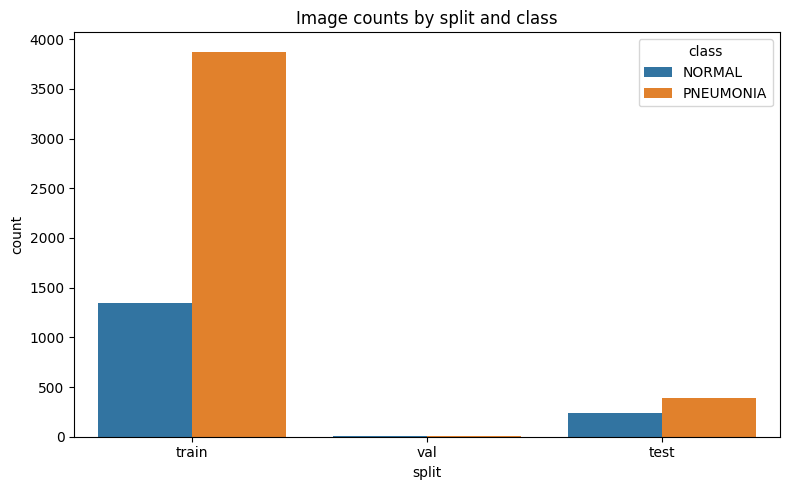

In [8]:
data_root = Path(cfg.data_dir)
assert data_root.exists(), f"Dataset root not found: {data_root}"

os.makedirs(os.path.join(cfg.output_dir,'figures'), exist_ok=True)
os.makedirs(os.path.join(cfg.output_dir,'results'), exist_ok=True)
os.makedirs(os.path.join(cfg.output_dir,'models'), exist_ok=True)

counts_df = class_counts(data_root)
counts_df.to_csv(f'{cfg.output_dir}/results/class_counts_by_split.csv', index=False)
display_df(counts_df)

plt.figure(figsize=(8,5))
sns.barplot(data=counts_df, x='split', y='count', hue='class')
plt.title('Image counts by split and class')
plt.tight_layout()
plt.savefig(os.path.join(cfg.output_dir,'figures', 'class_counts_by_split.png'), dpi=200)
plt.show()
plt.close()



### Adjust train/val

The current val set is far too small for reliable early stopping, tuning, and sanity checks the variance will be huge. We will adjust validation of ~15% of the training pool.

In [9]:
# 1. Load the current training and validation folder leave test untouched
train_dir = f"{cfg.data_dir}/train"
val_dir = f"{cfg.data_dir}/val"
test_dir = f"{cfg.data_dir}/test"

train_raw = datasets.ImageFolder(train_dir)
val_raw = datasets.ImageFolder(val_dir)

# ensure same class mapping
assert train_raw.class_to_idx == val_raw.class_to_idx, "train/val class_to_idx mismatch"

# combined (path, label) list
combined_samples = train_raw.samples + val_raw.samples
combined_paths   = [path for path, _ in combined_samples]
combined_labels  = [label for _, label in combined_samples]

# 2. Stratified re-split into new train/val
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=SEED)
new_train_idx, new_val_idx = next(sss.split(range(len(combined_labels)), combined_labels))

new_train_paths = [combined_paths[i] for i in new_train_idx]
new_train_labels= [combined_labels[i] for i in new_train_idx]
new_val_paths   = [combined_paths[i] for i in new_val_idx]
new_val_labels  = [combined_labels[i] for i in new_val_idx]

# 3. New split distribution
train_counts = Counter(new_train_labels)
val_counts   = Counter(new_val_labels)

# Map back to class names
idx_to_class = {v: k for k, v in train_raw.class_to_idx.items()}

total_train = sum(train_counts.values())
total_val   = sum(val_counts.values())

print("\nNew TRAIN percentages:")
for cls_idx, count in train_counts.items():
    print(f"  {idx_to_class[cls_idx]}: {count} ({count/total_train:.2%})")

print("\nNew VAL percentages:")
for cls_idx, count in val_counts.items():
    print(f"  {idx_to_class[cls_idx]}: {count} ({count/total_val:.2%})")




New TRAIN percentages:
  NORMAL: 1147 (25.79%)
  PNEUMONIA: 3300 (74.21%)

New VAL percentages:
  NORMAL: 202 (25.73%)
  PNEUMONIA: 583 (74.27%)


In [10]:
# Compute mean/std for 40% samples from the new train files

# 1. Random sample files
rng = random.Random(SEED)

# Group by class
by_cls = {}
for p, y in zip(new_train_paths, new_train_labels):
    by_cls.setdefault(y, []).append(p)

# Sample 40% from each class
sampled_files = []
for y, file_list in by_cls.items():
    n_to_sample = max(1, int(len(file_list) * 0.4))
    sampled_files.extend(rng.sample(file_list, n_to_sample))

sizes = []
total_pixels = 0
sum_pixels = 0.0
sumsq_pixels = 0.0

for p in tqdm(sampled_files, desc="Scanning images for EDA"):
    # Ensure file path is str/Path
    p = Path(p)
    # Always close images using context manager
    with Image.open(p) as img:
        sizes.append(img.size)
        g = ImageOps.grayscale(img)
        # numpy array for fast math; discard immediately after using
        arr = np.asarray(g, dtype=np.float32)

    n = arr.size
    total_pixels += n
    sum_pixels += float(arr.sum())
    sumsq_pixels += float((arr * arr).sum())

    # help GC on large loops
    del arr
    if total_pixels % (256*1024*1024) == 0:
        gc.collect()

# Compute mean & std safely
mean = sum_pixels / total_pixels
var = max(0.0, (sumsq_pixels / total_pixels) - (mean ** 2))
std = float(np.sqrt(var))

# Save sizes (small; one row per image)
sizes_df = pd.DataFrame(sizes, columns=['width', 'height'])
out_csv = Path(cfg.output_dir) / "results" / "image_sizes_sample.csv"
out_csv.parent.mkdir(parents=True, exist_ok=True)
sizes_df.to_csv(out_csv, index=False)




Scanning images for EDA: 100%|██████████| 1778/1778 [00:21<00:00, 84.49it/s] 


In [11]:
# 2. Compute mean and std
def compute_mean_std_from_sampled_files(files_path, crops_per_image = 4, resize_short = 256, crop_size = cfg.img_size) :
    channel_sum = None
    channel_sqsum = None
    count = 0

    for f in files_path:
        try:
            img = Image.open(f)
        except Exception:
            continue

        # Convert mode if needed
        if img.mode != 'RGB': img = img.convert('RGB')

        # Resize shortest side
        w, h = img.size
        scale = resize_short / float(min(w, h))
        new_w, new_h = max(1, int(w*scale)), max(1, int(h*scale))
        img_resized = img.resize((new_w, new_h), Image.BILINEAR)

        # Random crops
        for _ in range(crops_per_image):
            if new_w < crop_size or new_h < crop_size:
                left = max((new_w - crop_size)//2, 0)
                top  = max((new_h - crop_size)//2, 0)
            else:
                left = rng.randint(0, new_w - crop_size)
                top  = rng.randint(0, new_h - crop_size)
            crop = img_resized.crop((left, top, left+crop_size, top+crop_size))

            # Convert to tensor
            arr = np.asarray(crop, dtype=np.float32) / 255.0
            if arr.ndim == 2:
                arr = np.repeat(arr[..., None], 3, axis=2)
            arr = np.transpose(arr, (2,0,1))

            t = torch.from_numpy(arr)
            C = t.shape[0]
            if channel_sum is None:
                channel_sum = torch.zeros(C, dtype=torch.float64)
                channel_sqsum = torch.zeros(C, dtype=torch.float64)

            flat = t.view(C, -1)
            channel_sum += flat.mean(dim=1).double()
            channel_sqsum += (flat**2).mean(dim=1).double()
            count += 1

    mean = (channel_sum / max(count,1)).float()
    var  = (channel_sqsum / max(count,1) - mean.double().pow(2)).float()
    std  = torch.sqrt(torch.clamp(var, min=1e-8))
    return mean, std

train_mean, train_std = compute_mean_std_from_sampled_files(sampled_files)

print("\nSampled training images:")
print("Mean:", train_mean.tolist())
print("Std:", train_std.tolist())


Sampled training images:
Mean: [0.5600165724754333, 0.5600165724754333, 0.5600165724754333]
Std: [0.189881831407547, 0.189881831407547, 0.189881831407547]


## 6) Data Transforms & Dataloaders

In [12]:
# 1. Build transform using train stats
train_tf = transforms.Compose([
    transforms.RandomResizedCrop(cfg.img_size, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(train_mean.tolist(), train_std.tolist()),
])

val_tf = transforms.Compose([
    transforms.Resize(int(cfg.img_size*1.1)),
    transforms.CenterCrop(cfg.img_size),
    transforms.ToTensor(),
    transforms.Normalize(train_mean.tolist(), train_std.tolist()),
])

# 2. Wrap new test and validation split into datasets that read from file path
class PathsImageFolderLike(Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths = paths
        self.labels = labels
        self.transform = transform
    def __len__(self): return len(self.paths)
    def __getitem__(self, i):
        p, y = self.paths[i], self.labels[i]
        img = Image.open(p)
        if img.mode != 'RGB': img = img.convert('RGB')
        if self.transform: img = self.transform(img)
        return img, y

train_ds = PathsImageFolderLike(new_train_paths, new_train_labels, transform=train_tf)
val_ds = PathsImageFolderLike(new_val_paths, new_val_labels, transform=val_tf)

# 3. Test is untouched
test_ds  = datasets.ImageFolder(test_dir, transform=val_tf)

# 4. Dataloaders
train_loader = DataLoader(train_ds, batch_size = cfg.batch_size, shuffle=True,  num_workers = cfg.num_workers, pin_memory=cfg.pin_memory)
val_loader = DataLoader(val_ds, batch_size = cfg.batch_size, shuffle=False, num_workers = cfg.num_workers, pin_memory=cfg.pin_memory)
test_loader = DataLoader(test_ds, batch_size = cfg.batch_size, shuffle=False, num_workers = cfg.num_workers, pin_memory=cfg.pin_memory)

len(train_ds), len(val_ds) if val_ds else None, len(test_ds)

(4447, 785, 624)

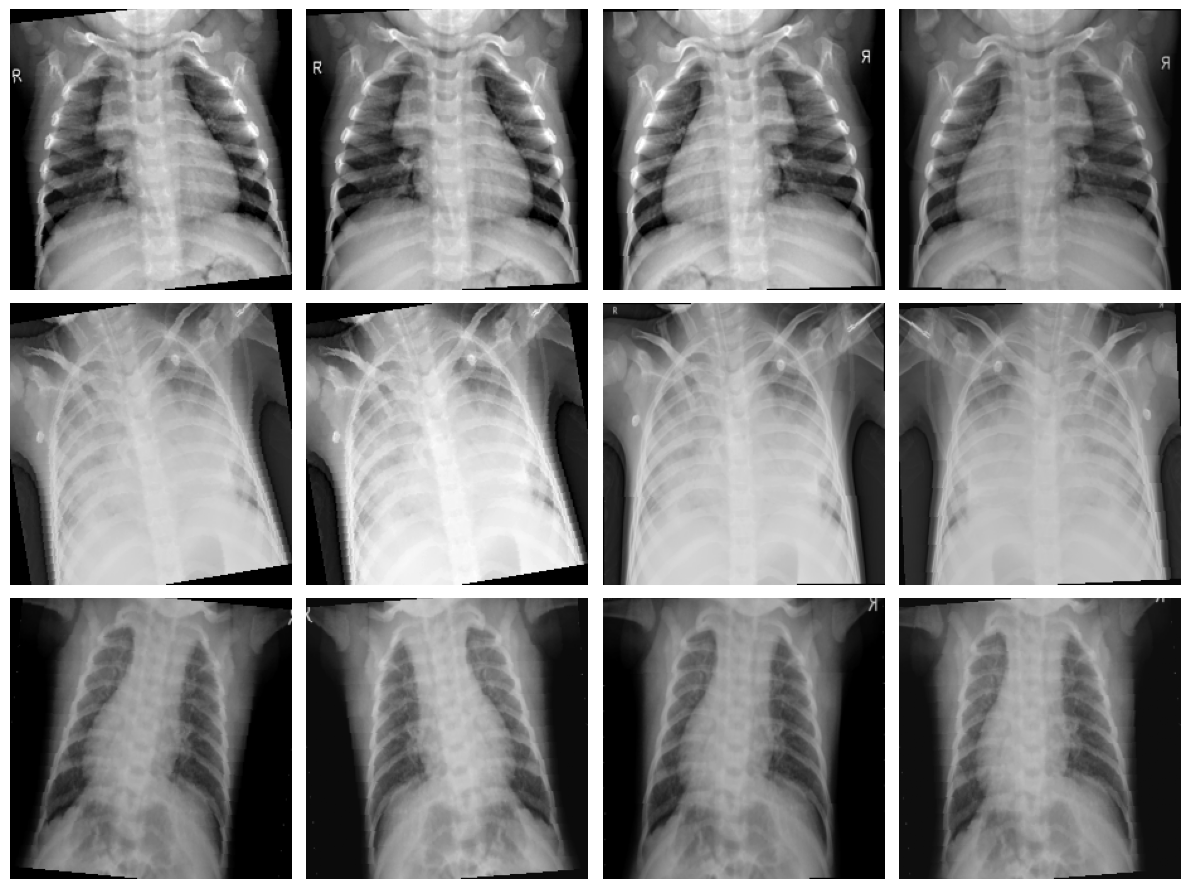

In [13]:
# Preview augmentations
preview_tf = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor()  # Keep values in [0,1]
])

sample_paths = random.sample(new_train_paths, 3)
n_augments = 4

fig, axes = plt.subplots(len(sample_paths), n_augments, figsize=(n_augments*3, len(sample_paths)*3))

for i, path in enumerate(sample_paths):
    img = Image.open(path).convert('RGB')
    for j in range(n_augments):
        aug_img = preview_tf(img)  # no normalization here
        aug_img_np = aug_img.permute(1, 2, 0).numpy()
        axes[i, j].imshow(aug_img_np)
        axes[i, j].axis("off")

plt.tight_layout()
plt.show()

## 7) Build Model CNN


In [14]:
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=1e-7,
    restore_best_weights=True,
)

plateau = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor = 0.2,
    patience = 2,
    min_delt = 1e-7,
    cooldown = 0,
    verbose = 1
)

In [15]:
def get_model():

    #Input shape = [width, height, color channels]
    inputs = layers.Input(shape=(cfg.img_size, cfg.img_size, 3))

    # Block One
    x = layers.Conv2D(filters=16, kernel_size=3, padding='valid')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.2)(x)

    # Block Two
    x = layers.Conv2D(filters=32, kernel_size=3, padding='valid')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.2)(x)

    # Block Three
    x = layers.Conv2D(filters=64, kernel_size=3, padding='valid')(x)
    x = layers.Conv2D(filters=64, kernel_size=3, padding='valid')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.4)(x)

    # Head
    #x = layers.BatchNormalization()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    #Final Layer (Output)
    output = layers.Dense(1, activation='sigmoid')(x)

    model = keras.Model(inputs=[inputs], outputs=output)

    return model

In [16]:
keras.backend.clear_session()

model_cnn = get_model()
model_cnn.compile(loss='binary_crossentropy',
              optimizer = keras.optimizers.Adam(learning_rate=3e-5),
              metrics=['binary_accuracy'])

model_cnn.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 222, 222, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 109, 109, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 50, 50, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 50, 50, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 40000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     2,560,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,621,089 (10.00 MB)

 Trainable params: 2,620,865 (10.00 MB)

 Non-trainable params: 224 (896.00 B)

In [ ]:
# def torch_loader_to_tf_dataset(loader, img_size=(224, 224)):
#     H, W = img_size
#     def gen():
#         for xb, yb in loader:
#             x = xb.detach().cpu().permute(0, 2, 3, 1).numpy().astype("float32")
#             y = yb.detach().cpu().numpy().astype("int32")
#             yield x, y

#     return tf.data.Dataset.from_generator(
#         gen,
#         output_signature=(
#             tf.TensorSpec(shape=(None, H, W, 3), dtype=tf.float32),
#             tf.TensorSpec(shape=(None,), dtype=tf.int32),
#         ),
#     )

# train_tf = torch_loader_to_tf_dataset(train_loader, img_size=(224, 224)).prefetch(tf.data.AUTOTUNE)
# val_tf = torch_loader_to_tf_dataset(val_loader, img_size=(224, 224)).prefetch(tf.data.AUTOTUNE)


In [ ]:
# %pip uninstall -y tensorflow tensorflow-cpu tensorflow-gpu nvidia-cublas-cu12 nvidia-cudnn-cu12 nvidia-cuda-runtime-cu12 nvidia-cusolver-cu12 nvidia-cusparse-cu12 nvidia-curand-cu12
# %pip install -q "tensorflow[and-cuda]==2.17.1"
# import os, IPython; os.kill(os.getpid(), 9)

In [ ]:
# import numpy as np
# m = tf.keras.Sequential([
#     tf.keras.layers.Input((224,224,3)),
#     tf.keras.layers.Conv2D(32, 3, activation="relu"),
#     tf.keras.layers.GlobalAveragePooling2D(),
#     tf.keras.layers.Dense(10)
# ])
# m.compile(optimizer="adam", loss="sparse_categorical_crossentropy")
# x = np.random.rand(8,224,224,3).astype("float32")
# y = np.random.randint(0,10,(8,))
# m.fit(x, y, epochs=1, verbose=2)


In [ ]:
# history_cnn = model_cnn.fit(train_tf,
#                     epochs = 50,
#                     validation_data=val_tf,
#                     callbacks=[early_stopping, plateau],
#                     steps_per_epoch=(len(train_ds)//cfg.batch_size),
#                     validation_steps=(len(val_ds)//cfg.batch_size),)

In [ ]:
# score_val_cnn = model_cnn.evaluate(val_loader, steps = len(val_ds)//cfg.batch_size, verbose = 0)
# print('Val loss:', score_val_cnn[0])
# print('Val accuracy:', score_val_cnn[1])

In [ ]:
# score_test_cnn = model_cnn.evaluate(test_loader, steps = len(test_ds), verbose = 0)

# print('Test loss:', score_test_cnn[0])
# print('Test accuracy:', score_test_cnn[1])

## 8) Build Model from `vit.py`


In [17]:

def evaluate(model, loader, device, criterion, debug_max_batches=None, debug_verbose=False):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    all_labels, all_preds = [], []
    for b, (imgs, labels) in enumerate(loader):
        if debug_max_batches is not None and b >= debug_max_batches:
            break
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        running_loss += loss.item() * imgs.size(0)
        preds = outputs.argmax(1)
        correct += outputs.argmax(1).eq(labels).sum().item()
        total += labels.size(0)

        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())

        if debug_verbose and b < 2:
            print(f"[EVAL] batch {b}: imgs {tuple(imgs.shape)} loss {loss.item():.4f}")

    # Calculate F1 score
    y_pred = torch.cat(all_preds).numpy()
    y_true = torch.cat(all_labels).numpy()
    # auto-pick averaging: 'binary' if exactly 2 classes, else 'macro'
    avg = 'binary' if len(np.unique(y_true)) == 2 else 'macro'
    f1 = f1_score(y_true, y_pred, average=avg)

    return (running_loss / max(total, 1)), (100. * correct / max(total, 1)), f1


def train_and_evaluate(model, model_name, lr, epochs, wd,
                       train_loader, val_loader, test_loader, device,
                       save_path = cfg.output_dir,
                       use_sam=False, sam_rho=0.05, sam_adaptive=True,
                       debug_max_batches=None, debug_fast_epochs=None, debug_verbose=False):

    criterion = nn.CrossEntropyLoss()
    if use_sam:
        optimizer = SAM(model.parameters(),
                        base_optimizer=torch.optim.AdamW,
                        lr=lr, weight_decay=wd,
                        rho=sam_rho, adaptive=sam_adaptive)
    else:
        optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)

    # allow capping epochs in debug
    n_epochs = min(epochs, debug_fast_epochs) if (debug_fast_epochs is not None) else epochs

    train_losses, train_accuracies = [], []
    val_losses, val_accuracies, val_f1s = [], [], []
    LR, WD = [],[]

    # Best model tracking
    best_f1, best_val_acc, best_val_loss = -1, 0.0, float('inf')
    best_model_wts = copy.deepcopy(model.state_dict())

    # Early stopping by accuracy
    patience = 5
    epochs_no_improve = 0

    for epoch in range(n_epochs):
        # Training
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for b, (imgs, labels) in enumerate(tqdm(train_loader,
                                                desc=f'{model_name} - Epoch {epoch+1}/{n_epochs} Training',
                                                leave=False)):
            if debug_max_batches is not None and b >= debug_max_batches:
                break

            imgs, labels = imgs.to(device), labels.to(device)
            if not use_sam:
                optimizer.zero_grad(set_to_none=True)
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
            else:
                # SAM two-step
                optimizer.zero_grad(set_to_none=True)
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.first_step(zero_grad=True)

                # second forward-backward on the same batch
                outputs2 = model(imgs)
                loss2 = criterion(outputs2, labels)
                loss2.backward()
                optimizer.second_step(zero_grad=True)

            with torch.no_grad():
                # track stats using the first outputs
                preds = outputs.argmax(1)
                running_loss += loss.item() * imgs.size(0)
                correct += preds.eq(labels).sum().item()
                total += labels.size(0)

            if debug_verbose and b < 2:
                print(f"[TRAIN] batch {b}: imgs {tuple(imgs.shape)} "
                      f"loss {loss.item():.4f} acc_batch {(preds.eq(labels).float().mean()*100):.2f}%")


        train_losses.append(running_loss / max(total, 1))
        train_accuracies.append(100. * correct / max(total, 1))

        # Validation
        val_loss, val_acc, val_f1 = evaluate(model, val_loader, device, criterion,
                                     debug_max_batches=debug_max_batches,
                                     debug_verbose=debug_verbose)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        val_f1s.append(val_f1)

        print(f'{model_name} - Epoch {epoch+1}/{epochs}: '
              f'Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}% | '
              f'Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.2f}% | Val F1: {val_f1:.4f}')

        # optimizer params
        for i, g in enumerate(optimizer.param_groups):
            LR.append(g['lr'])
            WD.append(g.get('weight_decay', 0))

    # Save best-by-F1
        if val_f1 > best_f1:
            best_f1 = val_f1
            best_f1_wts = copy.deepcopy(model.state_dict())
            torch.save(best_f1_wts, os.path.join(save_path, 'models', f"{model_name}_best_f1.pth"))
            print(f"New best F1: {best_f1:.4f} (epoch {epoch+1}) → saved {model_name}_best_f1.pth")

        # Save best model by loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            #torch.save(model.state_dict(), os.path.join(save_path, 'models', f"{model_name}_best_loss.pth"))
            print(f"New best loss: {best_val_loss:.4f} (epoch {epoch+1})")

        # Save best model by accuracy
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            epochs_no_improve = 0
            #torch.save(model.state_dict(), os.path.join(save_path, 'models', f"{model_name}_best_acc.pth"))
            print(f"New best acc: {best_val_acc:.2f}% (epoch {epoch+1})")
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print("Early stopping")
                break

    return {
        "train_losses": train_losses,
        "train_accuracies": train_accuracies,
        "val_losses": val_losses,
        "val_accuracies": val_accuracies,
        "val_f1s": val_f1s,
        "learning_rate": LR,
        "weight_decay": WD
    }


### Sanety check - Run on small dataset

In [18]:


# 1) make tiny datasets from the real DATASETS (not loaders)
small_train_dataset = Subset(train_loader.dataset, range(min(32, len(train_loader.dataset))))
small_val_dataset   = Subset(val_loader.dataset,   range(min(16, len(val_loader.dataset))))
small_test_dataset  = Subset(test_loader.dataset,  range(min(16, len(test_loader.dataset))))

# 2) make small loaders
small_train_loader = torch.utils.data.DataLoader(small_train_dataset, batch_size=8, shuffle=True,
                                                 num_workers=0, pin_memory=False, persistent_workers=False)
small_val_loader   = torch.utils.data.DataLoader(small_val_dataset,   batch_size=8, shuffle=False,
                                                 num_workers=0, pin_memory=False, persistent_workers=False)
small_test_loader  = torch.utils.data.DataLoader(small_test_dataset,  batch_size=8, shuffle=False,
                                                 num_workers=0, pin_memory=False, persistent_workers=False)

# grab 1 mini-batch from the (small) train loader
sample_img, _ = next(iter(small_train_loader))   # shape [B, C, H, W]
sample_img = sample_img[:1].cpu()

model_vit_debug = vit.ViTClassifier(sample_img, cfg.num_classes, cfg.d_model).to(device)

history_vit_debug = train_and_evaluate(
    model_vit_debug, "DryRunViT",
    lr=1e-4, epochs=1, wd=1e-4,
    train_loader=small_train_loader,
    val_loader=small_val_loader,
    test_loader=small_test_loader,
    device=device,
    use_sam=False,
    debug_max_batches=2,
    debug_fast_epochs=1,
    debug_verbose=True
)

history_vit_sam_debug = train_and_evaluate(
    model_vit_debug, "DryRunViT SAM",
    lr=1e-4, epochs=1, wd=1e-4,
    train_loader=small_train_loader,
    val_loader=small_val_loader,
    test_loader=small_test_loader,
    device=device,
    use_sam=True,
    debug_max_batches=2,
    debug_fast_epochs=1,
    debug_verbose=True
)


DryRunViT - Epoch 1/1 Training:  25%|██▌       | 1/4 [00:01<00:03,  1.04s/it]

[TRAIN] batch 0: imgs (8, 3, 224, 224) loss 0.5960 acc_batch 75.00%


[TRAIN] batch 1: imgs (8, 3, 224, 224) loss 0.9948 acc_batch 62.50%


[EVAL] batch 0: imgs (8, 3, 224, 224) loss 2.6564
[EVAL] batch 1: imgs (8, 3, 224, 224) loss 2.7149
DryRunViT - Epoch 1/1: Train Loss: 0.7954, Train Acc: 68.75% | Val Loss: 2.6857, Val Acc: 62.50% | Val F1: 0.7000
New best F1: 0.7000 (epoch 1) → saved DryRunViT_best_f1.pth
New best loss: 2.6857 (epoch 1)
New best acc: 62.50% (epoch 1)


DryRunViT SAM - Epoch 1/1 Training:  25%|██▌       | 1/4 [00:00<00:02,  1.31it/s]

[TRAIN] batch 0: imgs (8, 3, 224, 224) loss 2.6355 acc_batch 62.50%


[TRAIN] batch 1: imgs (8, 3, 224, 224) loss 0.7699 acc_batch 62.50%


[EVAL] batch 0: imgs (8, 3, 224, 224) loss 2.7484
[EVAL] batch 1: imgs (8, 3, 224, 224) loss 2.5041
DryRunViT SAM - Epoch 1/1: Train Loss: 1.7027, Train Acc: 62.50% | Val Loss: 2.6262, Val Acc: 31.25% | Val F1: 0.1538
New best F1: 0.1538 (epoch 1) → saved DryRunViT SAM_best_f1.pth
New best loss: 2.6262 (epoch 1)
New best acc: 31.25% (epoch 1)


### save to git before runnning

In [22]:
!git config --global user.email "noabd87@gmain.com"
!git config --global user.name "noabendavid"

!git add .
!git commit -m "Updated notebook before training"
!git push origin main

On branch main
Your branch is ahead of 'origin/main' by 1 commit.
  (use "git push" to publish your local commits)

nothing to commit, working tree clean
fatal: could not read Username for 'https://github.com': No such device or address


In [20]:
# Undo the last commit but keep changes
!git reset --soft HEAD~1
!git reset  # unstage everything

# Create .gitignore
!cat > .gitignore <<'EOF'
!__pycache__/
!*.pyc
!.ipynb_checkpoints/
!outputs/models/
!*.pth
!*.pt
!*.ckpt
!EOF

# Re-add & commit (respecting .gitignore)
!git add -A
!git commit -m "Update notebook & results (ignore large artifacts)"


/bin/bash: line 1: warning: here-document at line 1 delimited by end-of-file (wanted `EOF')
/bin/bash: line 1: __pycache__/: Is a directory
/bin/bash: line 1: *.pyc: command not found
/bin/bash: line 1: .ipynb_checkpoints/: No such file or directory
/bin/bash: line 1: outputs/models/: Is a directory
/bin/bash: line 1: *.pth: command not found
/bin/bash: line 1: *.pt: command not found
/bin/bash: line 1: *.ckpt: command not found
/bin/bash: line 1: EOF: command not found
[main 478f749] Update notebook & results (ignore large artifacts)
 8 files changed, 1786 insertions(+), 2 deletions(-)
 create mode 100644 __pycache__/sam.cpython-311.pyc
 create mode 100644 __pycache__/vit.cpython-311.pyc
 create mode 100644 outputs/figures/class_counts_by_split.png
 create mode 100644 outputs/models/DryRunViT SAM_best_f1.pth
 create mode 100644 outputs/models/DryRunViT_best_f1.pth
 create mode 100644 outputs/results/class_counts_by_split.csv
 create mode 100644 outputs/results/image_sizes_sample.csv


In [21]:
!git push origin main

fatal: could not read Username for 'https://github.com': No such device or address


### Train and Evaluate ViT

In [ ]:
sample_img, _ = next(iter(train_loader))
sample_img = sample_img[:1].to(device)

model_vit = vit.ViTClassifier(sample_img, cfg.num_classes, cfg.d_model).to(device)


history_vit = train_and_evaluate(
    model_vit, "ViT",
    lr=cfg.lr, epochs=cfg.epochs, wd=cfg.weight_decay,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    device=device,
    use_sam=False
)

model_vit_sam = vit.ViTClassifier(sample_img, cfg.num_classes, cfg.d_model).to(device)

history_vit_sam = train_and_evaluate(
    model_vit_sam, "ViT_SAM",
    lr=cfg.lr, epochs=cfg.epochs, wd=cfg.weight_decay,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    device=device,
    use_sam=True
)


### Plots & Curves

In [ ]:
def plot_curves(train_accuracies, val_accuracies, model_name, y_label, saved=cfg.output_dir):
    epochs = range(1, len(train_accuracies) + 1)

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_accuracies, 'b-', label= f'Train {y_label}')
    plt.plot(epochs, val_accuracies, 'g-', label= f'Validation {y_label}')
    plt.xlabel('Epoch')
    plt.ylabel(f'{y_label}')
    plt.title(f'{model_name} - Training and Validation {y_label}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(saved,'figures', f'{model_name}_Training_and_Validation_{y_label}.png'), dpi=200)
    plt.show()

In [ ]:
plot_curves(history_vit['train_accuracies'], history_vit['val_accuracies'], 'ViT', 'Accuracy')
plot_curves(history_vit_sam['train_accuracies'], history_vit_sam['val_accuracies'], 'ViT with SAM', 'Accuracy')


In [ ]:
plot_curves(history_vit['train_losses'], history_vit['val_losses'], 'ViT', 'Loss')
plot_curves(history_vit_sam['train_losses'], history_vit_sam['val_losses'], 'ViT with SAM', 'Loss')


## 9) Test Evaluation & models comparison

In [ ]:
def test_evaluation(model, ckpt_path, test_loader, device, save_path):
    all_preds = []
    all_labels = []
    all_probs = []
    test_correct = 0

    # state = torch.load(ckpt_path, map_location=device, weights_only=False)
    # model.load_state_dict(state['model'])
    model.load_state_dict(torch.load(ckpt_path))
    model.eval()

    with torch.no_grad():
        for X, y in tqdm(test_loader, desc='Test', leave=False):
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            probs = torch.softmax(outputs, dim=1)[:, 1]
            preds = outputs.argmax(1)

            #Accumulated results
            test_correct += (outputs.argmax(1) == y).sum().item()
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(y.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    # --- Metrics
    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)

    cm = confusion_matrix(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, target_names=["Normal", "Pneumonia"], output_dict=True)

    # --- Save classification report
    report_df = pd.DataFrame(report).transpose()
    report_df.to_csv(save_path, index=True)

    return {
        "all_probs": all_probs,
        "all_labels": all_labels,
        "all_preds": all_preds,
        "cm": cm,
        "report": report_df
    }


In [ ]:
# test_cnn = test_evaluation()
test_vit = test_evaluation(model_vit, ckpt_path=os.path.join(cfg.output_dir,'models', "ViT_best_f1.pth"), test_loader=test_loader, device=device, save_path=os.path.join(cfg.output_dir, 'results',"ViT_classification_report.csv"))

test_vit_sam = test_evaluation(model_vit_sam, ckpt_path=os.path.join(cfg.output_dir, 'models', "ViT_SAM_best_f1.pth"), test_loader=test_loader, device=device, save_path=os.path.join(cfg.output_dir,'results', "ViT_SAM_classification_report.csv"))